In [5]:
# For data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data files
def load_data(filename):
    sequences = []
    structures = []
    
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    current_seq = ""
    current_struct = ""
    
    for line in lines:
        line = line.strip()
        if not line:
            if current_seq:
                sequences.append(current_seq)
                structures.append(current_struct)
                current_seq = ""
                current_struct = ""
        else:
            # This format may need adjustment based on the actual file format
            parts = line.split()
            if len(parts) >= 2:  # Assuming format: amino_acid structure
                current_seq += parts[0]
                current_struct += parts[1]
    
    if current_seq:  # Add the last sequence
        sequences.append(current_seq)
        structures.append(current_struct)
    
    return sequences, structures

# Load training and test data
train_seq, train_struct = load_data('data/protein-secondary-structure.train')
test_seq, test_struct = load_data('data/protein-secondary-structure.test')

# Basic statistics
print(f"Training set: {len(train_seq)} proteins, {sum(len(s) for s in train_seq)} amino acids")
print(f"Test set: {len(test_seq)} proteins, {sum(len(s) for s in test_seq)} amino acids")

Training set: 3 proteins, 18111 amino acids
Test set: 3 proteins, 3526 amino acids


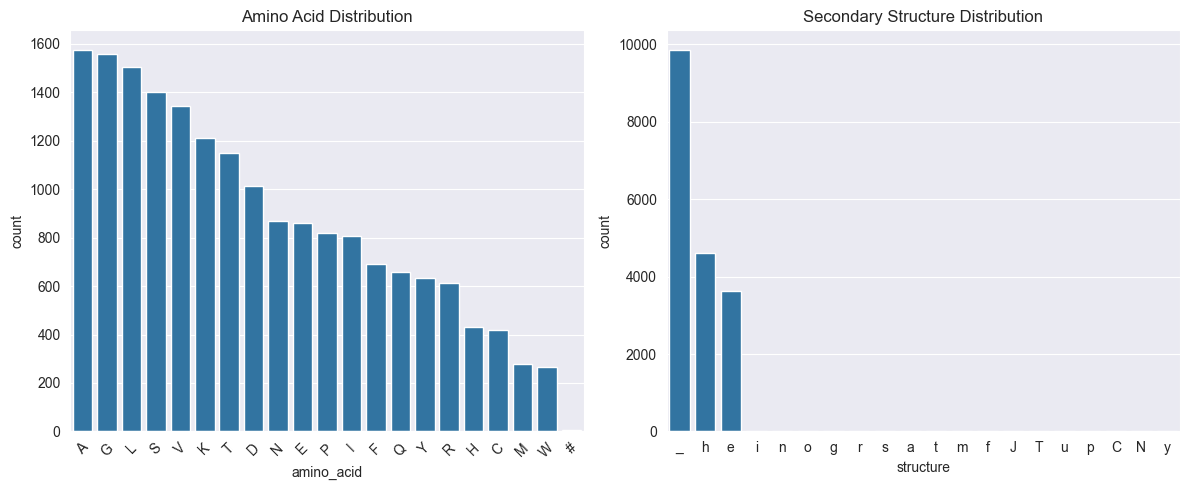

In [6]:
# Count amino acid frequencies
def count_amino_acids(sequences):
    aa_counts = {}
    for seq in sequences:
        for aa in seq:
            aa_counts[aa] = aa_counts.get(aa, 0) + 1
    return aa_counts

# Count secondary structure frequencies
def count_structures(structures):
    struct_counts = {}
    for struct in structures:
        for s in struct:
            struct_counts[s] = struct_counts.get(s, 0) + 1
    return struct_counts

train_aa_counts = count_amino_acids(train_seq)
train_struct_counts = count_structures(train_struct)

# Plot distributions
plt.figure(figsize=(12, 5))

# Amino acid distribution
plt.subplot(1, 2, 1)
aa_df = pd.DataFrame({'amino_acid': list(train_aa_counts.keys()), 
                      'count': list(train_aa_counts.values())})
aa_df = aa_df.sort_values('count', ascending=False)
sns.barplot(x='amino_acid', y='count', data=aa_df)
plt.title('Amino Acid Distribution')
plt.xticks(rotation=45)

# Secondary structure distribution
plt.subplot(1, 2, 2)
struct_df = pd.DataFrame({'structure': list(train_struct_counts.keys()), 
                         'count': list(train_struct_counts.values())})
struct_df = struct_df.sort_values('count', ascending=False)
sns.barplot(x='structure', y='count', data=struct_df)
plt.title('Secondary Structure Distribution')

plt.tight_layout()
plt.show()

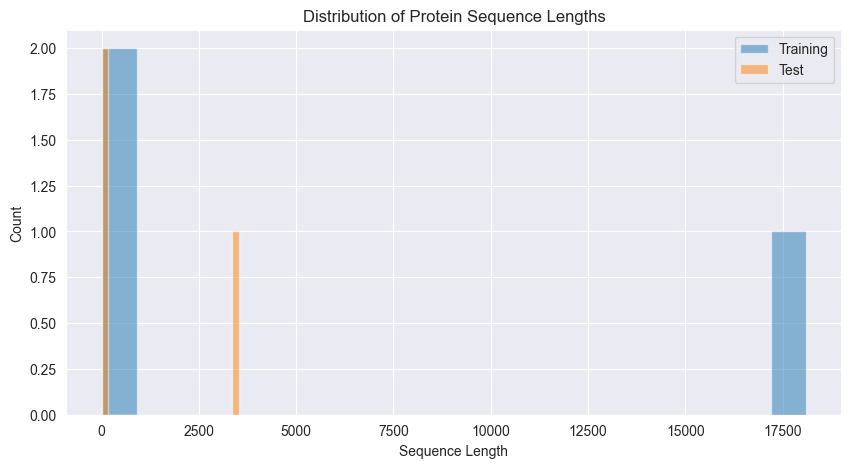

In [7]:
# Analyze sequence lengths
train_lengths = [len(seq) for seq in train_seq]
test_lengths = [len(seq) for seq in test_seq]

plt.figure(figsize=(10, 5))
plt.hist(train_lengths, bins=20, alpha=0.5, label='Training')
plt.hist(test_lengths, bins=20, alpha=0.5, label='Test')
plt.title('Distribution of Protein Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.legend()
plt.show()

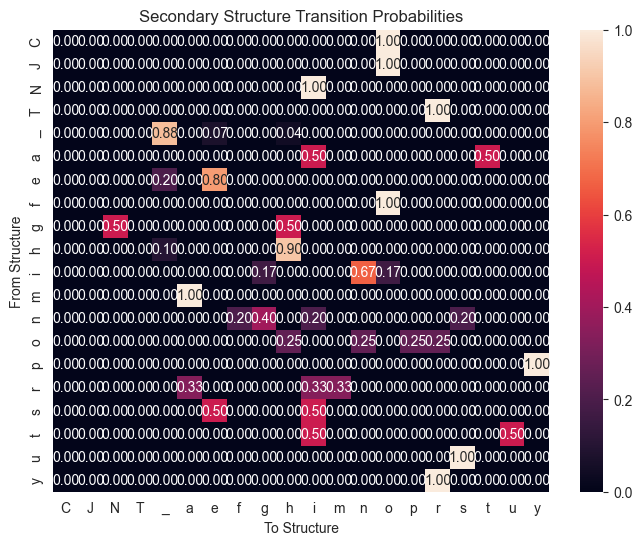

In [8]:
# Analyze structure transitions (which structure tends to follow another)
def analyze_transitions(structures):
    transitions = {}
    for struct in structures:
        for i in range(len(struct) - 1):
            current = struct[i]
            next_struct = struct[i + 1]
            if current not in transitions:
                transitions[current] = {}
            transitions[current][next_struct] = transitions[current].get(next_struct, 0) + 1
    return transitions

train_transitions = analyze_transitions(train_struct)

# Plot transition matrix
structures = sorted(list(set(''.join(train_struct))))
transition_matrix = np.zeros((len(structures), len(structures)))

for i, s1 in enumerate(structures):
    total = sum(train_transitions.get(s1, {}).values())
    for j, s2 in enumerate(structures):
        if s1 in train_transitions and s2 in train_transitions[s1]:
            transition_matrix[i, j] = train_transitions[s1][s2] / total

plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, fmt='.2f', 
            xticklabels=structures, yticklabels=structures)
plt.title('Secondary Structure Transition Probabilities')
plt.xlabel('To Structure')
plt.ylabel('From Structure')
plt.show()

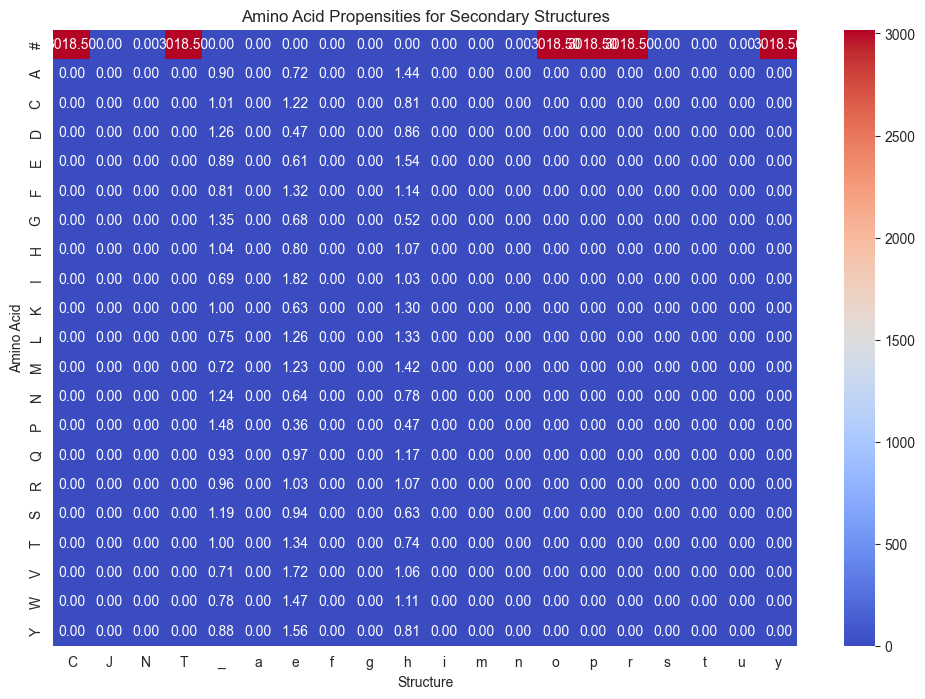

In [9]:
# Calculate propensity of each amino acid for each structure type
def calculate_propensities(sequences, structures):
    # Count occurrences of each amino acid in each structure
    aa_struct_counts = {}
    for seq, struct in zip(sequences, structures):
        for aa, ss in zip(seq, struct):
            if aa not in aa_struct_counts:
                aa_struct_counts[aa] = {}
            aa_struct_counts[aa][ss] = aa_struct_counts[aa].get(ss, 0) + 1
    
    # Calculate propensities
    all_aa = sorted(list(aa_struct_counts.keys()))
    all_structs = sorted(list(set(''.join(structures))))
    
    # Count total occurrences
    aa_totals = {aa: sum(aa_struct_counts[aa].values()) for aa in all_aa}
    struct_totals = {}
    for aa in all_aa:
        for ss in all_structs:
            struct_totals[ss] = struct_totals.get(ss, 0) + aa_struct_counts.get(aa, {}).get(ss, 0)
    total = sum(aa_totals.values())
    
    # Calculate propensities
    propensities = {}
    for aa in all_aa:
        propensities[aa] = {}
        for ss in all_structs:
            # Propensity = (P(aa|ss) / P(aa)) = (f(aa,ss)/f(ss)) / (f(aa)/f(total))
            f_aa_ss = aa_struct_counts.get(aa, {}).get(ss, 0)
            f_ss = struct_totals[ss]
            f_aa = aa_totals[aa]
            
            if f_ss > 0 and f_aa > 0:
                propensity = (f_aa_ss / f_ss) / (f_aa / total)
            else:
                propensity = 0
            propensities[aa][ss] = propensity
    
    return propensities

propensities = calculate_propensities(train_seq, train_struct)

# Plot propensities
propensity_data = []
for aa in propensities:
    for ss in propensities[aa]:
        propensity_data.append({
            'Amino Acid': aa,
            'Structure': ss,
            'Propensity': propensities[aa][ss]
        })

propensity_df = pd.DataFrame(propensity_data)
propensity_pivot = propensity_df.pivot(index='Amino Acid', columns='Structure', values='Propensity')

plt.figure(figsize=(12, 8))
sns.heatmap(propensity_pivot, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Amino Acid Propensities for Secondary Structures')
plt.show()

In [10]:
# Define constants
WINDOW_SIZE = 17  # Use 17 amino acids (8 on each side of the central amino acid)
AA_LETTERS = "ACDEFGHIKLMNPQRSTVWY"  # 20 standard amino acids
SS_LETTERS = "_he"  # Coil (_), helix (h), sheet (e) - based on your data visualization

# One-hot encode amino acids
def one_hot_encode_aa(aa):
    """Convert amino acid letter to one-hot encoding."""
    encoding = np.zeros(len(AA_LETTERS))
    if aa in AA_LETTERS:
        encoding[AA_LETTERS.index(aa)] = 1
    return encoding

# Create windows from sequences
def create_windows(sequences, structures, window_size):
    """
    Create sliding windows from sequences and their corresponding structure labels.
    
    Parameters:
    sequences -- List of amino acid sequences
    structures -- List of secondary structure sequences
    window_size -- Size of the window (odd number)
    
    Returns:
    X -- List of encoded windows
    y -- List of corresponding structure labels (for the central amino acid)
    """
    half_window = window_size // 2
    X = []
    y = []
    
    for sequence, structure in zip(sequences, structures):
        for i in range(len(sequence)):
            # Extract window
            window = ''
            for j in range(i - half_window, i + half_window + 1):
                if j < 0 or j >= len(sequence):
                    window += '-'  # Padding for positions outside sequence
                else:
                    window += sequence[j]
            
            # Encode window
            encoded_window = []
            for aa in window:
                if aa == '-':
                    encoded_window.extend(np.zeros(len(AA_LETTERS)))
                else:
                    encoded_window.extend(one_hot_encode_aa(aa))
            
            # Add to dataset
            X.append(encoded_window)
            
            # Encode structure (one-hot)
            if i < len(structure):
                ss = structure[i]
                ss_encoding = np.zeros(len(SS_LETTERS))
                if ss in SS_LETTERS:
                    ss_encoding[SS_LETTERS.index(ss)] = 1
                y.append(ss_encoding)
            else:
                # This should not happen if sequence and structure have the same length
                print(f"Warning: structure not found for position {i} in sequence")
    
    return np.array(X), np.array(y)

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Create window datasets
print(f"Creating window datasets with window size {WINDOW_SIZE}...")
X_train, y_train = create_windows(train_seq, train_struct, WINDOW_SIZE)
X_test, y_test = create_windows(test_seq, test_struct, WINDOW_SIZE)

print(f"Training examples: {X_train.shape[0]}")
print(f"Test examples: {X_test.shape[0]}")

# Create a validation set from the training data
from sklearn.model_selection import train_test_split

X_train_subset, X_val, y_train_subset, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

print(f"Training subset examples: {X_train_subset.shape[0]}")
print(f"Validation examples: {X_val.shape[0]}")

# Build model
print("Building neural network model...")
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(SS_LETTERS), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train model
print("Training model...")
history = model.fit(
    X_train_subset, y_train_subset,
    validation_data=(X_val, y_val),  # Use explicit validation set instead of validation_split
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

Creating window datasets with window size 17...
Training examples: 18111
Test examples: 3526
Training subset examples: 16299
Validation examples: 1812
Building neural network model...
Training model...
Epoch 1/30


C:\Users\eriks\Documents\MOL3022\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4852 - loss: 1.0210 - val_accuracy: 0.5822 - val_loss: 0.8738
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6039 - loss: 0.8601 - val_accuracy: 0.6225 - val_loss: 0.8163
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6379 - loss: 0.8019 - val_accuracy: 0.6198 - val_loss: 0.8040
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6672 - loss: 0.7601 - val_accuracy: 0.6225 - val_loss: 0.8021
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6759 - loss: 0.7475 - val_accuracy: 0.6214 - val_loss: 0.8002
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6912 - loss: 0.7139 - val_accuracy: 0.6253 - val_loss: 0.7993
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7077 - loss: 0.6826 - val_accuracy: 0.6291 - val_loss: 0.7990
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7249 - loss: 0.6594 - val_accuracy: 0.6385 - val_

In [13]:
# Evaluate model
print("Evaluating model...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Coil', 'Helix', 'Sheet']))

Evaluating model...
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6330 - loss: 0.8180
Test accuracy: 0.6228
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
Classification Report:
              precision    recall  f1-score   support

        Coil       0.68      0.80      0.74      1928
       Helix       0.53      0.43      0.48       849
       Sheet       0.49      0.37      0.42       749

    accuracy                           0.62      3526
   macro avg       0.57      0.54      0.55      3526
weighted avg       0.61      0.62      0.61      3526


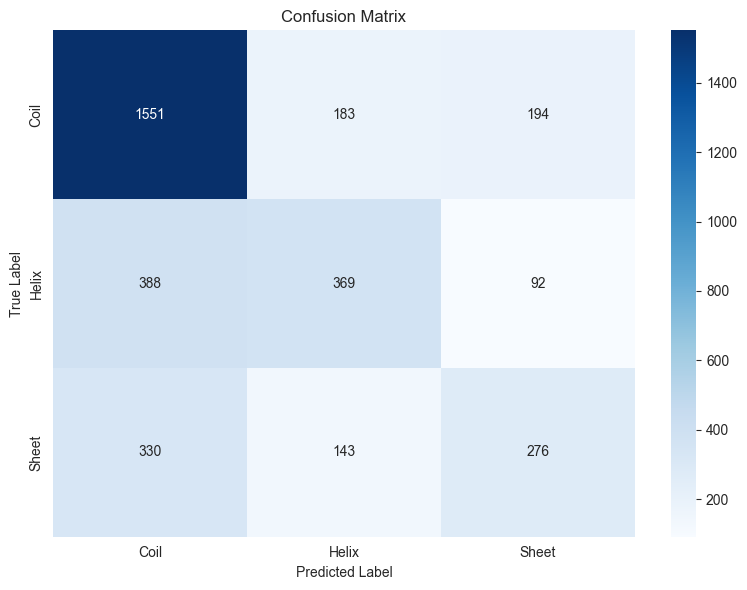

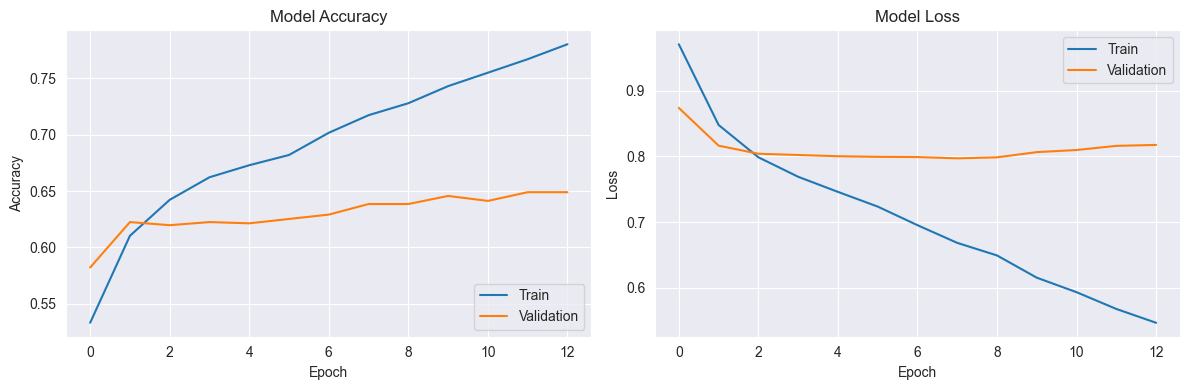

In [14]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Coil', 'Helix', 'Sheet'],
            yticklabels=['Coil', 'Helix', 'Sheet'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [15]:
# Function to make predictions on a new sequence
def predict_structure(sequence, model, window_size=WINDOW_SIZE):
    """Predict secondary structure for a protein sequence"""
    half_window = window_size // 2
    predicted_structure = ""
    
    for i in range(len(sequence)):
        # Extract window
        window = ""
        for j in range(i - half_window, i + half_window + 1):
            if j < 0 or j >= len(sequence):
                window += '-'  # Padding for positions outside sequence
            else:
                window += sequence[j]
        
        # Encode window
        encoded_window = []
        for aa in window:
            if aa == '-':
                encoded_window.extend(np.zeros(len(AA_LETTERS)))
            else:
                encoded_window.extend(one_hot_encode_aa(aa))
        
        # Make prediction
        encoded_window = np.array([encoded_window])
        prediction = model.predict(encoded_window, verbose=0)[0]
        predicted_class = np.argmax(prediction)
        predicted_structure += SS_LETTERS[predicted_class]
    
    return predicted_structure

# Example of how to use prediction function with a sample sequence
example_seq = "MKVLWAALLVTFLAGCQAKVEQAVETEPEPELRQQTEWQSGQRWELA"
predicted_ss = predict_structure(example_seq, model)

print("\nExample prediction:")
print("Sequence: ", example_seq)
print("Predicted: ", predicted_ss)


Example prediction:
Sequence:  MKVLWAALLVTFLAGCQAKVEQAVETEPEPELRQQTEWQSGQRWELA
Predicted:  hhhhhhhhhhhhhh___h________________hhh_____hhheh
